# Robust Estimation and Reconstruction

In this notebook, we experiment with RANSAC, a simple stereo setup and epipolar geometry

## Task 1 - RANSAC (40%)

Implement a RANSAC scheme for a given line fitting problem.  
In this implementation, a line can be simply defined by a pair of 2 points, it is not necessary to derive a line equation.  
For your RANSAC implementation, use 500 iterations and a threshold of 0.5.  
Draw your result using the provided functions.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt


# caclulates the distance between test_pt and a line defined by line_pt1 and line_pt2
def distance(test_pt, line_pt1, line_pt2):
    d = np.linalg.norm(np.cross(line_pt2-line_pt1, line_pt1-test_pt)) / np.linalg.norm(line_pt2-line_pt1)
    return d


# draws a line defined by line_pt1 and line_pt2
def drawLine(line_pt1, line_pt2):
    plt.axline(line_pt1, line_pt2, color = 'blue')


# draws all points
def drawPoints(pts):
    for pt in pts:
        plt.plot(pt[0], pt[1], 'ro')



# define the data points
pts = np.array([[0.9, 1],[5,4],[1.2, 4],[5, 2],[2.1, 1.87],[2.4, 2.6],[3.9, 4],[5.2, 5],
                [3.1, 2.95],[3.4, 3.2],[4.5, 4.4],[1.5, 3.5],[1.4, 1.35],[1.2, 1.22],
                [4.8, 4.5],[4.4, 4.6],[3.6, 3.7],[4.7, 4.8],[2, 4.5],[4.7, 2.2],
                [4, 1.5],[2.8,2.8],[3,1.5],[1.1,3]])

best Inliers: 16


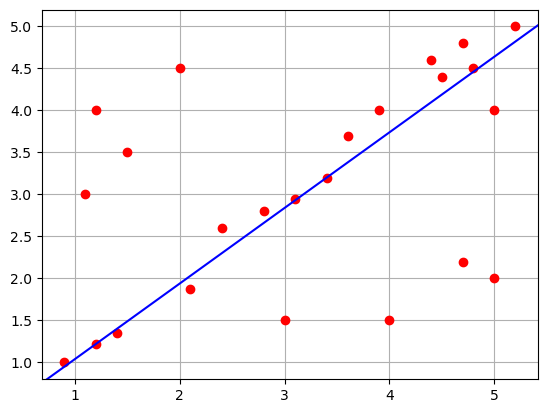

In [7]:
# YOUR CODE HERE
def ransac_line(pts, num_iterations, threshold):
    best_line = [pts[0], pts[1]]
    best_inliers = 0

    for _ in range(num_iterations):
        random_indices = np.random.choice(len(pts), 2, replace = False)
        line_pt1, line_pt2, = pts[random_indices]

        inliers = sum(distance(pt, line_pt1, line_pt2) < threshold for pt in pts)

        if inliers > best_inliers:
            best_inliers = inliers
            best_line = [line_pt1, line_pt2]

    print("best Inliers:", best_inliers)
    return best_line

num_iterations = 500
threshold = 0.5

best_line = ransac_line(pts, num_iterations, threshold)

drawPoints(pts)
drawLine(best_line[0], best_line[1])
plt.grid('on')
plt.show()



## Task 2 - Scene Reconstruction from Stereo Setup (40%)

Read the disparity image 'disparity.pgm' as grayscale image. Loop though every pixel and calculate the depth value.  
As the dispartiy image contains values between 0-255, assume a conversion scale factor from the intensity values to meter of 0,0001.  
For the focal distance use 40 mm and as baseline 0,4 m.  
Assume the principal point exactly at the center of the image at [100, 72]  

Fill your calculated x, y, and z values in the vectors pts_x_3d, pts_y_3d, pts_z_3d, which will be displayed in an interactive 3D plot

In [1]:
import cv2 as cv
import plotly.graph_objects as go

disparity = cv.imread('disparity.pgm', cv.IMREAD_UNCHANGED)

pts_x_3d = []
pts_y_3d = []
pts_z_3d = []


# YOUR CODE HERE
#disparity = cv.cvtColor(disparity, cv.COLOR_)
height, width = disparity.shape

focal_length = 40 
baseline = 0.4
principal_point = [100, 72]

scale_factor = 0.0001

for y in range(height):
    for x in range(width):
        disparity_value = disparity[y, x]
        if disparity_value > 0:
            depth = (focal_length * baseline) / (disparity_value * scale_factor)

            pts_x_3d.append((x - principal_point[0]) * depth / focal_length)
            pts_y_3d.append((y - principal_point[1]) * depth / focal_length)
            pts_z_3d.append(depth)
        

fig = go.Figure(data= [go.Scatter3d(x=pts_x_3d, y=pts_y_3d, z=pts_z_3d,
                                    mode='markers',
                                    marker=dict(
                                        size=1,
                                        color=pts_z_3d,         # set color to an array/list of desired values
                                        colorscale='Viridis',   # choose a colorscale
    ))])

camera = dict(eye=dict(x=0., y=-1., z=-1.))
fig.update_layout(scene_aspectmode='cube', scene_camera=camera)  # equal axis scale and default view point
fig.show()


## Task 3 - Multiview Setup (20%)

Given the two images 'fountain_left.png' and 'fountain_right.png', we want to find the corresponding Fundamental Matrix via 2D matches.  
Based on the Fundamental Matrix, we want to draw the two points with the pixel coordinates [400, 150] and [290, 50] in the left image, and draw the corresponding epipolar lines on the right image.  
For this task, you can use the code from here https://docs.opencv.org/3.4/da/de9/tutorial_py_epipolar_geometry.html, try to understand it and adapt it accordingly.

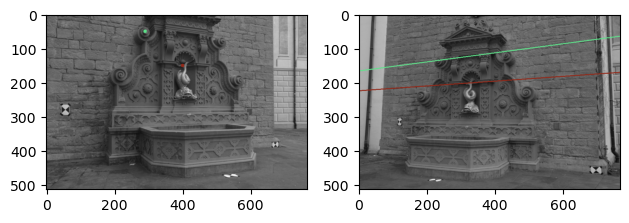

In [58]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

image_left = cv.imread('fountain_left.png', cv.IMREAD_GRAYSCALE)
image_right = cv.imread('fountain_right.png', cv.IMREAD_GRAYSCALE)

sift = cv.SIFT_create()

kp1, des1 = sift.detectAndCompute(image_left, None)
kp2, des2 = sift.detectAndCompute(image_right, None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k = 2)

pts1 = []
pts2 = []

for i, (m,n) in enumerate(matches):
    if m.distance < 0.8 * n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)


pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_LMEDS)

pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

def drawlines(img1,img2,lines,pts):
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt in zip(lines,pts):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img2 = cv.line(img2, (x0,y0), (x1,y1), color,2)
        img1 = cv.circle(img1,tuple(pt),5,color,-1)
    return img1,img2  

pixel_coords = np.array([[400, 150], [290, 50]])

lines = cv.computeCorrespondEpilines(pixel_coords.reshape(-1,1,2), 1,F)
lines = lines.reshape(-1,3)
img_pts,img_lines = drawlines(image_left,image_right,lines,pixel_coords)

# Display the images
plt.subplot(121), plt.imshow(img_pts)
plt.subplot(122), plt.imshow(img_lines)
plt.tight_layout()
plt.show()